### 손글씨 데이터셋 (MNIST)을 활용한 분류모델

In [17]:
# 기본 라이브러리 불러오기
import numpy as np              # 수치연산
import pandas as pd             # DataFrame 처리
import matplotlib.pyplot as plt # 시각화 (그래프)
import seaborn as sns           # 시각화 (차트)

# torch 계열 라이브러리
import torch                    # Pytorch 핵심 패키지
import torch.nn as nn           # 신경망 레이어/모듈
import torch.nn.functional as F # 활성화/손실 함수 등 함수 API
import torch.optim as optim     # 최적화함수 Optimizer

# 데이터셋 및 전처리
from torchvision import datasets, transforms # 기본 데이터셋 로딩, 데이터셋 전처리

# 검증
from sklearn.metrics import confusion_matrix # 혼동행렬 계산

### MNIST (손글씨 숫자 이미지) 데이터셋 다운로드 및 전처리

In [18]:
# 학습용 (MNIST Train) 데이터셋
train = datasets.MNIST(             # MNIST 학습 데이터셋 객체 생성
    './data',                       # 데이터 저장 경로
    train=True,                     # 학습(train) 데이터셋 사용
    download=True,                  # 없으면 인터넷에서 다운로드
    transform=transforms.Compose([  # 전처리를 순서대로 적용 (전처리 파이프라인)
        transforms.ToTensor(),      # PIL/ndarray -> torch.Tensor(0~1 스케일)
    ])
)

# 테스트용 (MNIST Test) 데이터셋
test = datasets.MNIST(
    './data',
    train=False,                    # 테스트(test) 데이터셋 사용
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

In [19]:
img, label = train[0]  # 0번째 샘플에서 (이미지 텐서, 정답 라벨) 추출
img.shape              # 이미지 텐서 모양 확인  (1, 28, 28) : (채널, 높이, 너비)

torch.Size([1, 28, 28])

- Pytorch(MNIST), Conv : cannel-first(C, H, W)
- Numpy / OpenCV / matplotlib / Tensorflow : channel-last(H, W, C)

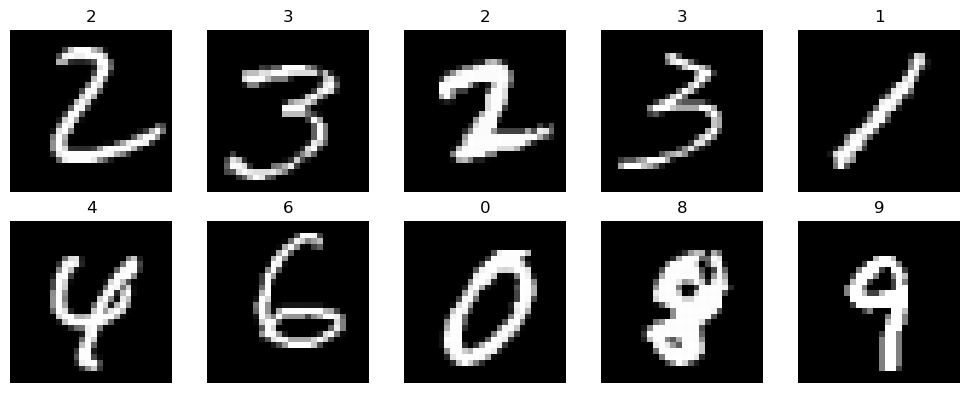

In [20]:
# 학습데이터 랜덤으로 10장 확인
idxs = np.random.choice(len(train), size = 10, replace = False) # 전체 중 랜덤 10개 인덱스

plt.figure(figsize = (10, 4))
for i, idx in enumerate(idxs):
    img, label = train[idx]  # 랜덤 샘플 (이미지 텐서, 라벨)
    plt.subplot(2, 5, i + 1) # 2행 5열
    plt.imshow(img.squeeze(0), cmap = 'gray') # (1, 28, 28) -> (28, 28)
    plt.title(label)
    plt.axis('off') # 축 제거

plt.tight_layout()
plt.show()

plt.imshow() 에서 받는 형태   
흑백 : (H, W) 
컬러 : (H, W, C)   
컬러 이미지의 경우 Pytorch 데이터셋이 (C, H, W) 형태라면 imshow()로 출력하기 위해서는 (H, W, C) 형태로 변환해야 합니다.

```python
img_hwc = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
plt.imshow(img_hwc)
```

### MNIST 입력 / 정답 텐서 전처리 및 차원 확인

In [21]:
# 이미지 정규화 및 실수형 변환
X = train.data.float() / 255. # 0~1로 스케일링
y = train.targets             # 각 이미지 정답 라벨 (텐서)

# 입력 텐서 형태 변환
X = X.view(X.size(0), -1)     # (N, 28, 28) -> (N, 784)로 펼쳐짐(flatten)
print(X.shape, y.shape)       # X : (N, 784), y : (샘플수, )

torch.Size([60000, 784]) torch.Size([60000])


In [22]:
# 입력/출력 차원 정의
input_size = X.size(-1)
output_size = int(max(y)) + 1

print(f"input_size : {input_size}, output_size : {output_size}")

input_size : 784, output_size : 10


- 학습 / 검증 / 테스트 데이터셋 분리 및 정규화

In [23]:
# 학습/검증 데이터셋 비율 설정 및 개수 계산
ratios = [.8, .2]

train_cnt = int(X.size(0)) * ratios[0]
valid_cnt = int(X.size(0)) * ratios[1]
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print(f"Train_cnt = {train_cnt}, Valid_cnt = {valid_cnt}, Test_cnt = {test_cnt}")

Train_cnt = 48000.0, Valid_cnt = 12000.0, Test_cnt = 10000


In [ ]:
# 학습/검증 데이터셋 무작위 셔플
indices = torch.randperm(X.size(0)) # 0 ~ N-1 인덱스 랜덤 순서로 생성

X = torch.index_select(X, dim = 0, index = indices)
y = torch.index_select(y, dim = 0, index = indices)

X = list(X.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))



TypeError: split_with_sizes(): argument 'split_sizes' (position 2) must be tuple of ints, but found element of type float at pos 0

In [ ]:
# 테스트데이터 정규화 및 추가
X +=